In [17]:
import pandas as pd
import numpy as np
import h5py
from sklearn.metrics import mean_absolute_error
from disaggregate.im2seq_clean import Im2Seq

In [18]:
# 0. (define data loader
def load_data_for_im2seq(h5_path, appliance, building='building2', max_ratio=1.0):
    with h5py.File(h5_path, 'r') as f:
        mains  = f[f'{building}/mains/power/active'][:]
        target = f[f'{building}/{appliance}/power/active'][:]
    L = min(len(mains), len(target))
    mains, target = mains[:L], target[:L]
    if max_ratio < 1.0:
        cut = int(L * max_ratio)
        mains, target = mains[:cut], target[:cut]
    return (
      pd.DataFrame(mains,  columns=['mains']),
      pd.DataFrame(target, columns=[appliance])
    )

In [19]:
# 1. Load your data
mains_df, app_df = load_data_for_im2seq('./data/REFIT_House2.h5',
                                        appliance='fridge_freezer',
                                        max_ratio=0.5)

print(f"Loaded mains_df with shape: {mains_df.shape}")

Loaded mains_df with shape: (2866763, 1)


In [ ]:
# 2. Slice out your test chunk
test_start, test_len = 2500000, 50000
X_test_df = mains_df.iloc[test_start:test_start+test_len]
Y_test_df = app_df.iloc  [test_start:test_start+test_len]

In [21]:
# 3. Compute the fridge’s train-time mean & std
fridge_freezer_mean = app_df['fridge_freezer'].mean()
fridge_freezer_std  = app_df['fridge_freezer'].std()



In [22]:
# 4. Instantiate Im2Seq exactly as during training
im2seq = Im2Seq({
    'sequence_length': 450,
    'img_method':      'gasf',      # match your training
    'img_size':        450,         # must match model.input_shape[1]
    'batch_size':      40,
    'appliance_params': {
      'fridge_freezer': {'mean': fridge_freezer_mean, 'std': fridge_freezer_std}
    }
})

In [23]:
# 5. Build the network and load its weights
im2seq.models['fridge_freezer'] = im2seq.return_network()
im2seq.models['fridge_freezer'].load_weights(
    'Im2Seq-gasf-450-simple-fridge_freezer-weights.h5'
)


In [24]:
_ = im2seq.call_preprocessing(
    [mains_df],                  # full-length mains (used for computing mean/std)
    [('fridge_freezer', [app_df])],      # full-length fridge data
    method='train'
)

# 6. Now do your test-mode preprocessing
processed = im2seq.call_preprocessing(
    [X_test_df],
    None,
    method='test'
)

In [25]:
# 6. Run end-to-end disaggregation
pred_dfs = im2seq.disaggregate_chunk(processed)
pred_full = pred_dfs[0]['fridge_freezer'].values          # aligned to length == len(Y_test_df)


L = im2seq.sequence_length
pred_trimmed = pred_full[L//2 : -(L//2)]  

1251/1251 [==============================] - 411s 324ms/step


In [26]:
# 7. Evaluate
mae = mean_absolute_error(Y_test_df.squeeze().values, pred_trimmed)
print("MAE:", mae)

MAE: 15.208407


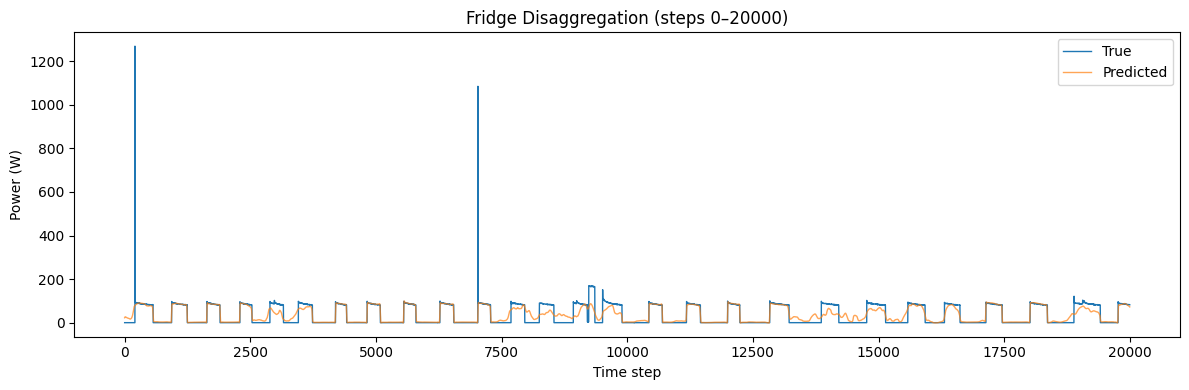

In [27]:
import matplotlib.pyplot as plt

# choose the segment you want
start_idx, end_idx = 0, 20000

true_seg = Y_test_df.values.squeeze()[start_idx:end_idx]
pred_seg = pred_trimmed        [start_idx:end_idx]

# if you want the x-axis to show the absolute time steps:
x = np.arange(start_idx, end_idx)

plt.figure(figsize=(12,4))
plt.plot(x, true_seg, label='True', linewidth=1)
plt.plot(x, pred_seg, label='Predicted', alpha=0.7, linewidth=1)
plt.title(f"Fridge Disaggregation (steps {start_idx}–{end_idx})")
plt.xlabel("Time step")
plt.ylabel("Power (W)")
plt.legend()
plt.tight_layout()
plt.show()
